`conda activate imgpro`

# Latency Analysis v2

Loads `*_processed_data.h5` (from `quantify_voxels.py`) and `metadata.json`, normalises the ratiometric signal (R/R₀ when baseline exists, R/F₂₀ otherwise), detects per-voxel response latency, and visualises results.

All reusable functions live in `latency_analysis.py`.

# 1. Imports & Configuration

In [ ]:
import importlib
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tifffile

import latency_analysis as la
importlib.reload(la)

%matplotlib inline

font = {'family': 'Arial', 'weight': 'normal', 'size': 20}
matplotlib.rc('font', **font)

In [239]:
# ============================================================================
# DATA PATH — point to the worm directory containing *_processed_data.h5
# ============================================================================
# input_dir = r'D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'
# input_dir = r'D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm004'
# input_dir = r'D:\DATA\g5ht-free\20260123\date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm005'
# input_dir = r'D:\DATA\g5ht-free\20260217\date-20260217_strain-ISg5HT-nsIS180_condition-fedpatch_worm003'
# input_dir = r'D:\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm003'
# input_dir = r'D:\DATA\g5ht-free\20260113\date-20260113_strain-ISg5HT-ADF-TeTx_condition-starvedpatch_worm004'
input_dir = r'D:\DATA\g5ht-free\20260206\date-20260206_strain-ISg5HT-mod-5_condition-fedpatch_worm003'


# ============================================================================
# EPOCH WINDOWS  (pre/post are NOT in metadata — specify per analysis)
# ============================================================================
# for date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001
pre_window  = (82, 123)
post_window = (141, 181)

# # for date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm004
# pre_window  = (564, 584)
# post_window = (678, 705)

# # for date-20260123_strain-ISg5HT-nsIS180_condition-fedpatch_worm005
# pre_window  = (108, 161)
# post_window = (171, 213)

# ============================================================================
# PREPROCESSING PARAMETERS
# ============================================================================
bin_factor       = 4      # extra spatial binning on top of h5 resolution
rfp_thresh       = 20.0   # minimum mean-RFP for mask inclusion
zero_prob_thresh = 5.0    # max % of time a voxel can be zero
keep_width       = None   # (x_start, x_end) or None

# ============================================================================
# ANALYSIS PARAMETERS
# ============================================================================
top_n_voxels     = None     # None = all, int = top-N by variance
preprocess_method = 'raw'   # 'raw', 'zscore', 'center'
n_std            = 2.0      # significance threshold (baseline std)
min_consecutive  = 5        # sustained frames required for latency
smooth_sigma     = 3.0      # causal Gaussian sigma before detection
min_response_prob = 0.02    # min fraction of time significant

print("Configuration set.")

Configuration set.


# 2. Load & Normalize Data

In [240]:
# Load processed h5 data
h5 = la.load_from_h5(input_dir)

# Extract metadata fields
fps             = h5['fps']
baseline_window = h5['baseline_window']   # tuple or None
encounter_frame = h5['encounter_frame']   # int or None
bad_frames      = h5['bad_frames']
time_vec        = h5['time_vec']
frame_index     = h5['frame_index']

# Normalize: R/R0 when baseline exists, R/F20 otherwise
normalized = la.normalize_ratio(
    h5['ratio'],
    baseline=h5.get('baseline'),
    f20=h5['f20'],
    baseline_window=baseline_window,
)

print(f"\nfps = {fps:.4f}")
print(f"baseline_window = {baseline_window}")
print(f"encounter_frame = {encounter_frame}")
print(f"bad_frames: {len(bad_frames)} frames")

Loading D:\DATA\g5ht-free\20260206\date-20260206_strain-ISg5HT-mod-5_condition-fedpatch_worm003\date-20260206_strain-ISg5HT-mod-5_condition-fedpatch_worm003_processed_data.h5
  ratio: (464, 39, 200, 500), fps=1.8762
  baseline_window=(np.int64(0), np.int64(20)), encounter_frame=65
  bad_frames: 14 frames
  Normalization: R/R0 (baseline mean)
  Normalized range: [0.000, 1960.000]

fps = 1.8762
baseline_window = (np.int64(0), np.int64(20))
encounter_frame = 65
bad_frames: 14 frames


# 3. Preprocess, Flatten, Select Voxels

In [242]:
# Preprocess: bin, mask, quality-filter
processed = la.preprocess_ratio(
    normalized,
    rfp_mean=h5['rfp_mean'],
    fixed_mask=h5['fixed_mask'],
    bin_factor=bin_factor,
    rfp_thresh=rfp_thresh,
    zero_prob_thresh=zero_prob_thresh,
    keep_width=keep_width,
)

data_4d       = processed['data']        # (T, Z, H, W)
mask_3d       = processed['mask']        # (Z, H, W) bool
spatial_shape = processed['spatial_shape']

# Flatten to 2D and apply mask
data_flat, mask_flat = la.flatten_and_mask(data_4d, mask_3d)
print(f"Flattened: {data_flat.shape}  (T x valid_voxels)")

# Select top-N voxels by variance (or all)
data_selected, selected_indices = la.select_top_n_voxels(data_flat, top_n_voxels)
print(f"Selected:  {data_selected.shape}")

# Apply optional preprocessing (raw / zscore / center)
g5 = la.apply_preprocessing(data_selected, preprocess_method)
print(f"\nSpatial shape: {spatial_shape}")

  Removed 37220 voxels with >5.0% zeros
  Preprocessed: (464, 39, 50, 125), mask voxels: 93416
Flattened: (464, 93416)  (T x valid_voxels)
  Using all 93416 voxels
Selected:  (464, 93416)
  Preprocessing: raw

Spatial shape: (39, 50, 125)


# 4. Visualize Data

In [ ]:
%matplotlib inline
plt.close('all')

# Representative z-slices at a chosen frame
frame_to_show = 178
fig = la.plot_representative_slices(data_4d, mask_3d, frame=frame_to_show)
plt.show()

In [ ]:
# Activity heatmap (sorted by variance)
import sys
import importlib
_ = importlib.reload(sys.modules['latency_analysis'])
%matplotlib inline
fig = la.plot_voxel_heatmap(g5, fps, time_window=(0, 200), max_voxels=40000, vmax_pct=98, cmap='plasma', figsize=(6,9))
plt.show()

In [ ]:
# Top-10 voxel traces with causal smoothing
%matplotlib inline

max_voxels = 10
voxel_metric = np.nanmean(g5, axis=0)
sort_idx = np.argsort(voxel_metric)[::-1]
n_show = min(max_voxels, g5.shape[1])
g5_top = g5[:, sort_idx[:n_show]]

smoothed = la.causal_smooth(g5_top, sigma=5.0)
plt.figure()
plt.plot(smoothed)
plt.xlabel('Frame'); plt.ylabel('Activity')
plt.title('Top voxels (sigma=5)')
plt.show()

smoothed2 = la.causal_smooth(g5_top, sigma=2.0, truncate=20.0)
plt.figure()
plt.plot(smoothed2)
plt.xlabel('Frame'); plt.ylabel('Activity')
plt.title('Top voxels (sigma=2)')
plt.show()

# 5. Response Statistics & Latency Detection

In [249]:
# Compute response statistics
n_std = 3.0
min_consecutive = 7
response_stats = la.compute_response_statistics(
    data=g5,
    baseline_window=(None,None) if baseline_window is None else baseline_window,
    pre_window=pre_window,
    post_window=post_window,
    n_std=n_std,
    min_consecutive=min_consecutive,
    smooth_sigma=smooth_sigma,
    detection_start=baseline_window[1] if baseline_window is not None else 0,
    min_response_prob=min_response_prob,
)

# Unpack commonly used arrays
significant_mask = response_stats.significant_mask
latency = response_stats.latency

# Summary
n_responsive = int(np.sum(response_stats.is_responsive))
n_with_lat   = int(np.sum(~np.isnan(latency)))
print(f"Total voxels:              {len(latency)}")
print(f"Responsive voxels:         {n_responsive}")
print(f"Voxels with latency:       {n_with_lat}")
print(f"Median latency:            {np.nanmedian(latency):.1f} frames  ({np.nanmedian(latency)/fps:.2f} s)")
print(f"Latency range:             {np.nanmin(latency):.0f} – {np.nanmax(latency):.0f} frames")

Total voxels:              93416
Responsive voxels:         14603
Voxels with latency:       14827
Median latency:            108.0 frames  (57.56 s)
Latency range:             21 – 437 frames


# 6. Latency Plots

c:\Users\munib\POSTDOC\CODE\g5ht-pipeline\utils.py:122: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


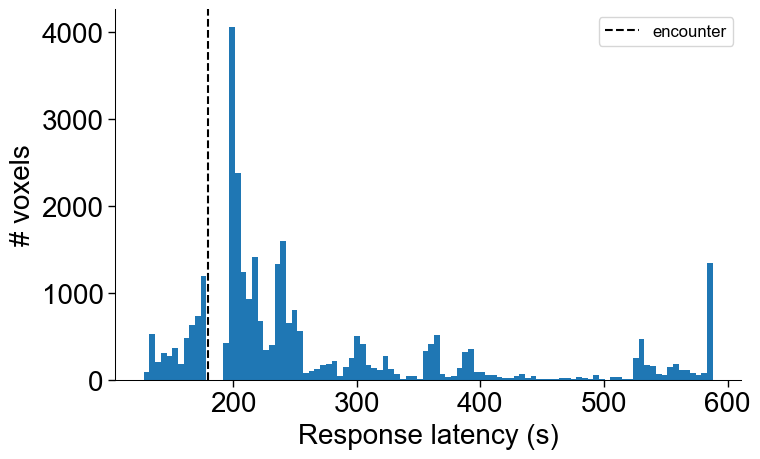

In [198]:
# Latency histogram
%matplotlib inline
fig = la.plot_latency_histogram(latency, fps, encounter_frame=encounter_frame)
plt.show()

In [ ]:
# Latency-sorted heatmaps (activity + significance mask)
fig_act, fig_sig = la.plot_latency_sorted_heatmap(
    g5, latency, significant_mask, num2plot=10000,
)
plt.show()

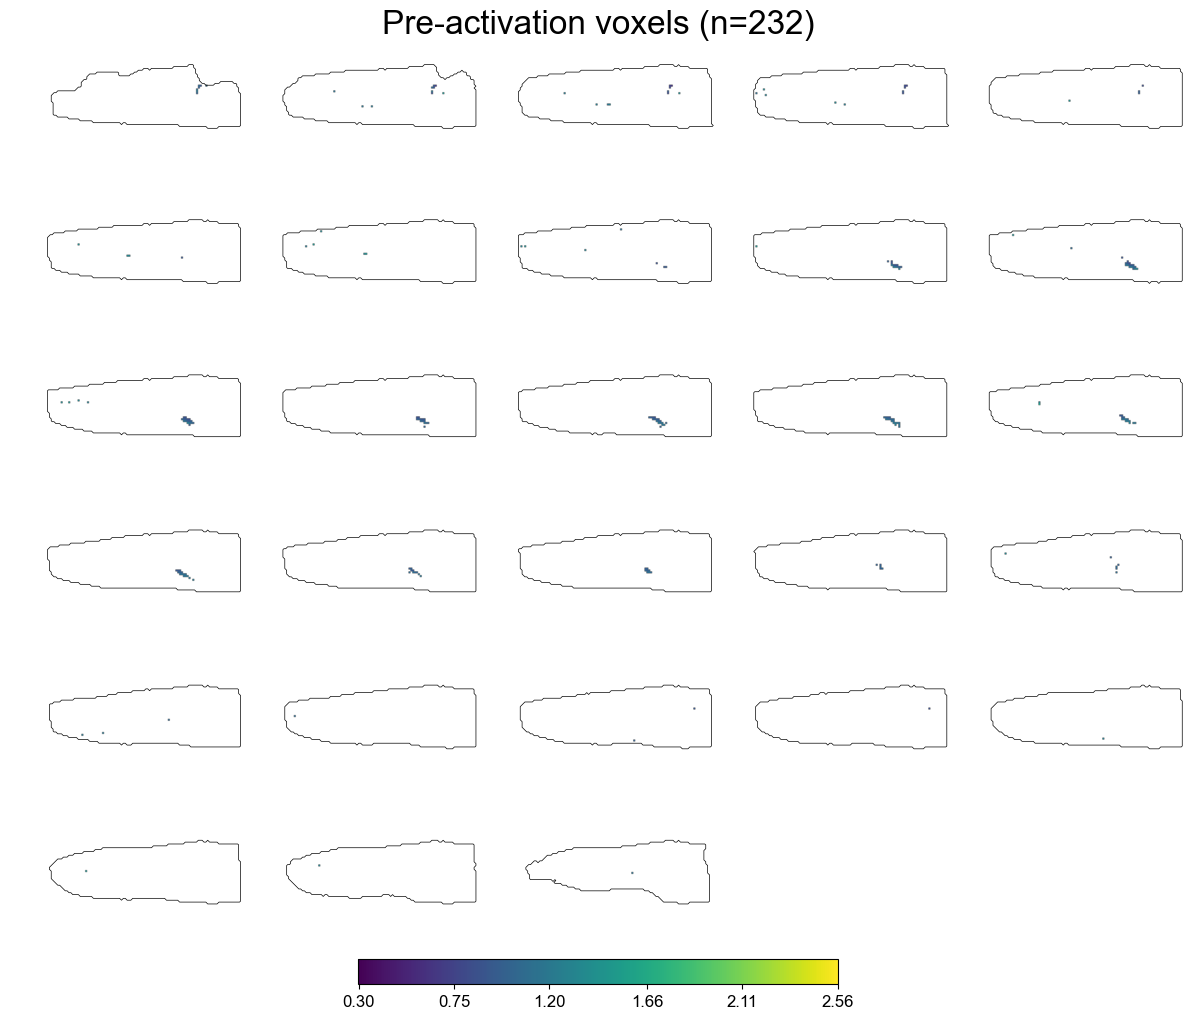

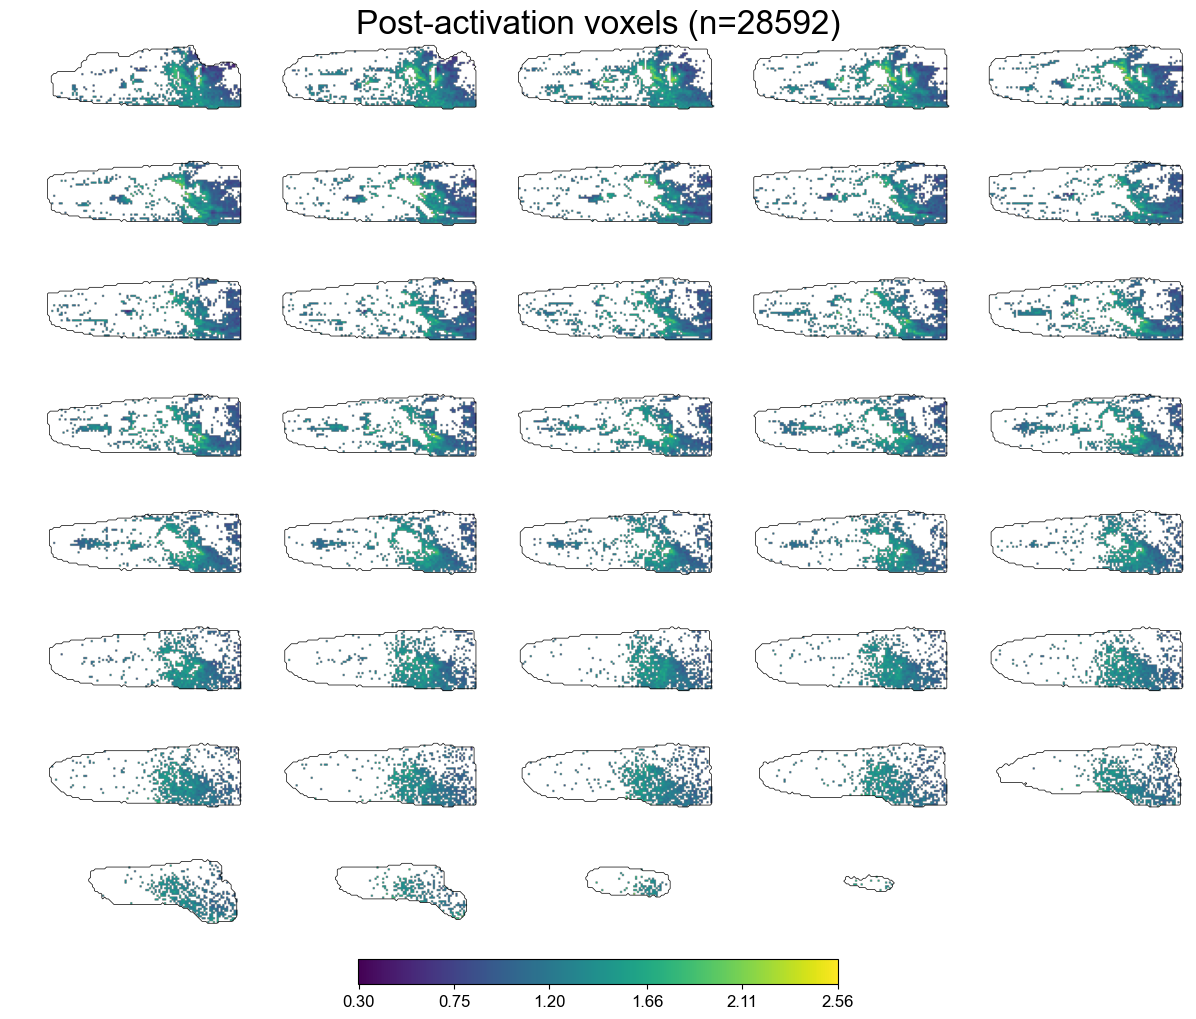

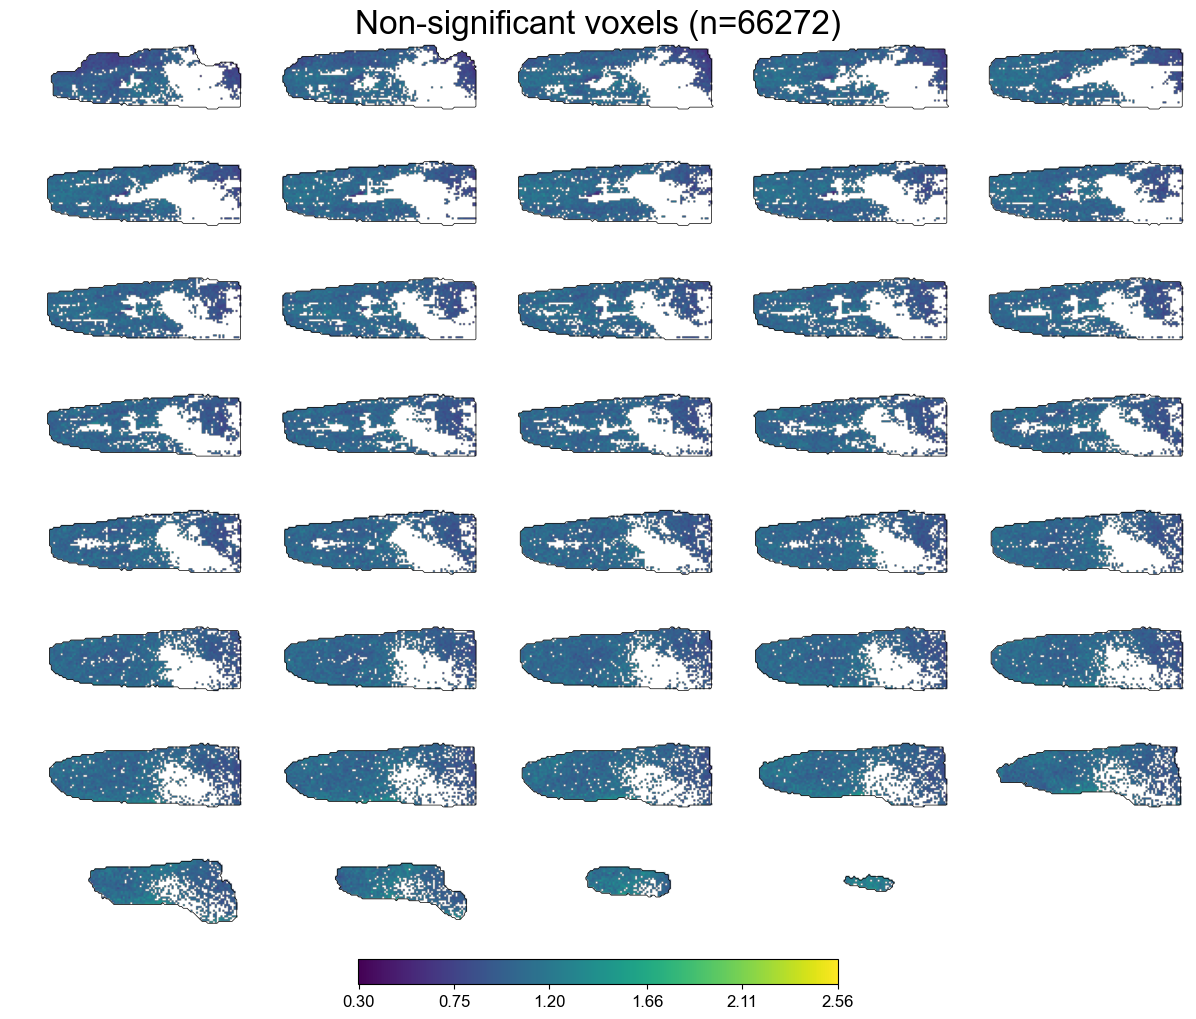

In [229]:
# Spatial maps: pre-activation, post-activation, non-significant voxels
vmin = np.nanpercentile(g5, 1)
vmax = np.nanpercentile(g5, 99)

# Pre-activation voxels (latency < pre_window end)
pre_voxels = np.where(latency < pre_window[1])[0]
if len(pre_voxels) > 0:
    mean_pre = np.nanmean(g5[pre_window[0]:pre_window[1], pre_voxels], axis=0)
    fig = la.plot_voxel_spatial_map(
        mean_pre, pre_voxels, selected_indices, mask_flat, mask_3d, spatial_shape,
        vmin=vmin, vmax=vmax,
    )
    fig.suptitle(f'Pre-activation voxels (n={len(pre_voxels)})', y=1.0)
    plt.show()

# Post-activation voxels (latency > post_window start)
post_voxels = np.where(latency > post_window[0])[0]
if len(post_voxels) > 0:
    mean_post = np.nanmean(g5[post_window[0]:post_window[1], post_voxels], axis=0)
    fig = la.plot_voxel_spatial_map(
        mean_post, post_voxels, selected_indices, mask_flat, mask_3d, spatial_shape,
        vmin=vmin, vmax=vmax,
    )
    fig.suptitle(f'Post-activation voxels (n={len(post_voxels)})', y=1.0)
    plt.show()

# Non-significant voxels (latency is NaN)
nonsig_voxels = np.where(np.isnan(latency))[0]
if len(nonsig_voxels) > 0:
    mean_ns = np.nanmean(g5[pre_window[0]:post_window[1], nonsig_voxels], axis=0)
    fig = la.plot_voxel_spatial_map(
        mean_ns, nonsig_voxels, selected_indices, mask_flat, mask_3d, spatial_shape,
        vmin=vmin, vmax=vmax,
    )
    fig.suptitle(f'Non-significant voxels (n={len(nonsig_voxels)})', y=1.0)
    plt.show()

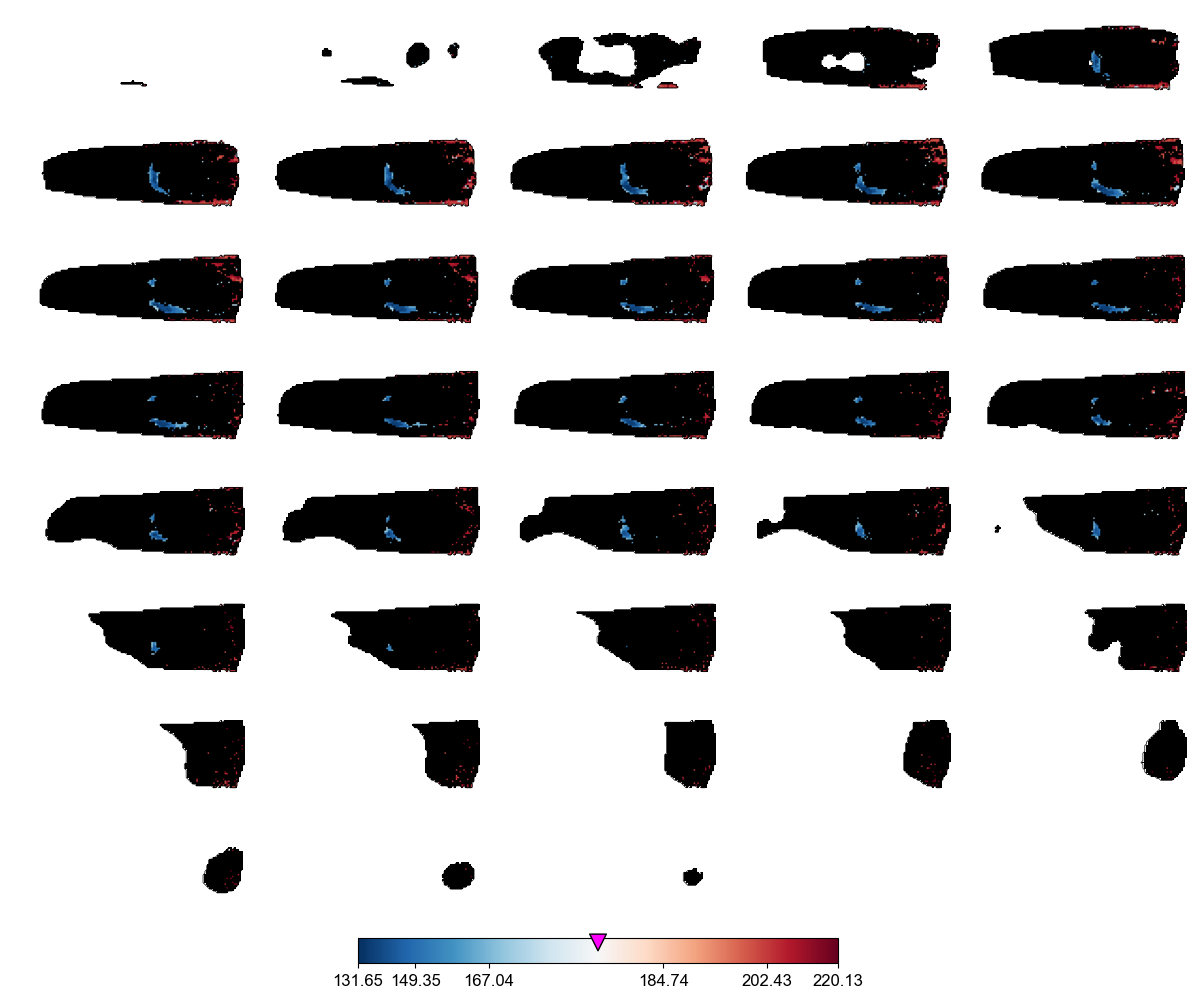

In [184]:
# Latency spatial map (coloured by response onset time)
# CenteredPowerNorm places encounter_time at the centre of the cmap (white for RdBu_r).
# mask_bg='black' fills masked-but-empty pixels with black.
%matplotlib inline
fig = la.plot_latency_spatial_map(
    latency, fps,
    selected_indices, mask_flat, mask_3d, spatial_shape,
    encounter_frame=encounter_frame,
    gamma=0.6,
    cmap='RdBu_r',
    max_latency_offset=40.0,
    mask_bg='black',
)
plt.show()

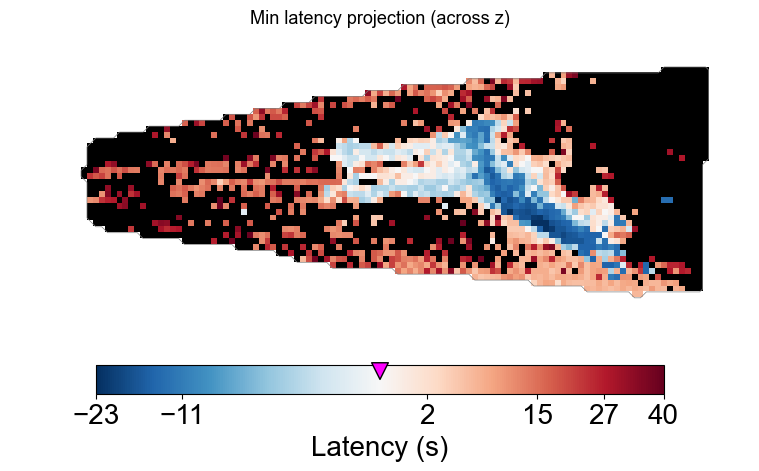

In [252]:
# Min-latency projection across all z-slices
import sys
import importlib
_ = importlib.reload(sys.modules['latency_analysis'])

from matplotlib.colors import PowerNorm
from latency_analysis import CenteredPowerNorm

# latency[latency<260.] = np.nan  # only show voxels with latency > 139 frames (i.e. post-activation)
gamma = 0.6
fig = la.plot_latency_min_projection(
    latency, fps,
    selected_indices, mask_flat, mask_3d, spatial_shape,
    encounter_frame=encounter_frame,
    gamma=gamma,
    cmap='RdBu_r',
    max_latency_offset=40.0,
    mask_bg='black',
    encounter_aligned=True,
    norm_cmap=CenteredPowerNorm(vmin=-20, vmax=40, vcenter=0, gamma=gamma)
)
plt.show()

In [ ]:
# Latency window spatial maps (relative to encounter)
if encounter_frame is not None:
    figs = la.plot_latency_window_maps(
        latency, fps, g5, encounter_frame,
        selected_indices, mask_flat, mask_3d, spatial_shape,
        windows=[(-30, -21), (-20, -11), (-10, -1), (0, 2), (3, 6), (7, 15)],
    )
    for fig, label in figs:
        plt.show()
else:
    print("No encounter_frame set — skipping latency window maps.")

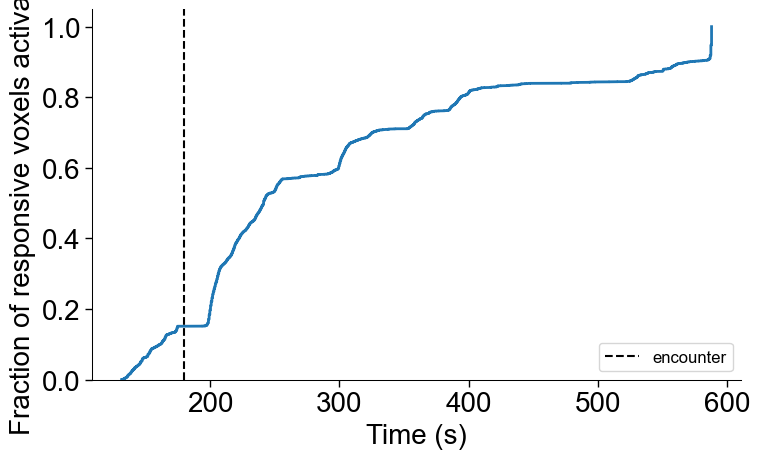

In [185]:
# Latency CDF (cumulative fraction of responsive voxels activated over time)
fig = la.plot_latency_cdf(latency, fps, encounter_frame=encounter_frame)
plt.show()

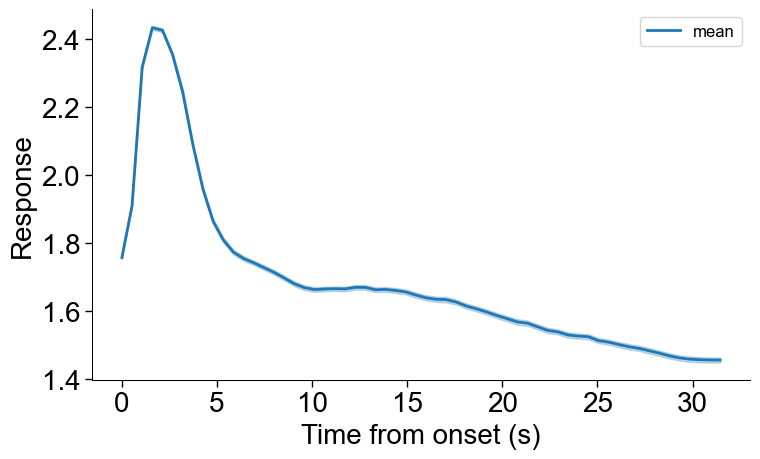

In [186]:
# Mean response waveform (aligned to each voxel's onset time)
fig = la.plot_mean_response_onset(
    g5, latency, fps,
    encounter_frame=encounter_frame,
    window_frames=60,
    smooth_sigma=2.0,
)
plt.show()

# 7. ROI-Level Latency Analysis (optional)

Requires `roi.tif` with ImageJ labels in the worm directory. If it doesn't exist, this section is skipped.

ROI shape: (39, 200, 500), labels: ['metacorpus', 'terminal_bulb', 'isthmus', 'nerve_ring', 'ventral_nerve_cord', 'procorpus']
  metacorpus: 737 responsive voxels, median latency = 41.04 s
  terminal_bulb: 1095 responsive voxels, median latency = 42.64 s
  isthmus: 1616 responsive voxels, median latency = 37.31 s
  nerve_ring: 1778 responsive voxels, median latency = 34.11 s
  ventral_nerve_cord: 88 responsive voxels, median latency = 111.40 s
  procorpus: 203 responsive voxels, median latency = 61.83 s


c:\Users\munib\POSTDOC\CODE\g5ht-pipeline\utils.py:122: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


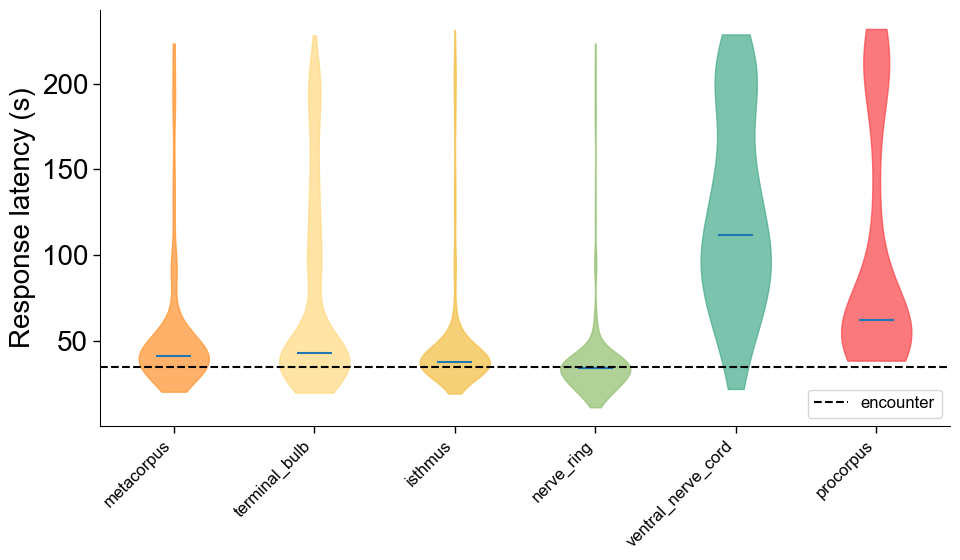

In [253]:
roi_path = os.path.join(input_dir, 'roi.tif')

# Predefined hex colors for each ROI label (consistent across datasets)
ROI_COLORS = {
    # long-form labels
    'procorpus':          '#F94144',
    'metacorpus':         '#FF9129',
    'isthmus':            '#F3BD3E',
    'terminal_bulb':      '#FFD981',
    'nerve_ring':         '#90BE6D',
    'ventral_nerve_cord': '#43AA8B',
    'dorsal_nerve_cord':  '#000000',
    # short-form labels
    'PC':                 '#F94144',
    'MC':                 '#FF9129',
    'IM':                 '#F3BD3E',
    'TB':                 '#FFD981',
    'NR':                 '#90BE6D',
    'VNC':                '#43AA8B',
    'DNC':                '#000000',
}

if os.path.exists(roi_path):
    with tifffile.TiffFile(roi_path) as tif:
        roi = tif.asarray()
        roi_labels = tif.imagej_metadata.get('Labels', [])
        # # remove 'dorsal_nerve_cord' label if present
        # if 'dorsal_nerve_cord' in roi_labels:
        #     idx = roi_labels.index('dorsal_nerve_cord')
        #     roi_labels.pop(idx)
        #     roi[roi == (idx + 1)] = 0  # set corresponding ROI pixels to 0
    print(f"ROI shape: {roi.shape}, labels: {roi_labels}")

    roi_latency = la.compute_roi_latency_stats(
        latency, selected_indices, mask_flat,
        roi, roi_labels, spatial_shape,
        bin_factor=bin_factor,
    )

    for label, lat_arr in roi_latency.items():
        med = np.median(lat_arr) / fps if len(lat_arr) > 0 else float('nan')
        print(f"  {label}: {len(lat_arr)} responsive voxels, median latency = {med:.2f} s")

    fig = la.plot_roi_latency_comparison(
        roi_latency, fps, encounter_frame=encounter_frame, roi_colors=ROI_COLORS,
    )
    plt.show()
else:
    print(f"roi.tif not found in {input_dir} — skipping ROI analysis.")

c:\Users\munib\POSTDOC\CODE\g5ht-pipeline\utils.py:122: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


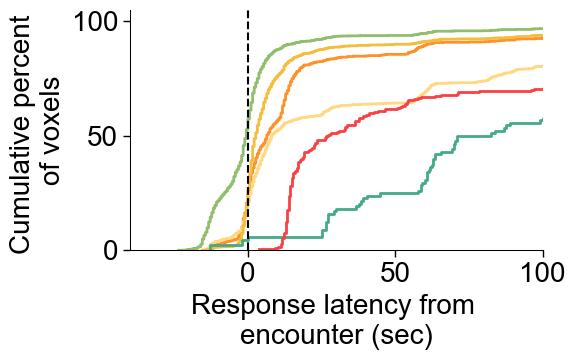

In [254]:
import sys
import importlib
_ = importlib.reload(sys.modules['latency_analysis'])
from latency_analysis import plot_roi_latency_cdf
# Latency CDF by ROI
if roi_latency:
    fig = la.plot_roi_latency_cdf(
        roi_latency, fps, encounter_frame=encounter_frame, roi_colors=ROI_COLORS,
    )
    plt.xlim((-40,100))
    # save figure as svg with a transparent background
    fig.savefig(os.path.join(input_dir, 'roi_latency_cdf.svg'), transparent=True)
    plt.show()

# 8. Save Results

In [ ]:
analysis_params = dict(
    bin_factor=bin_factor,
    rfp_thresh=rfp_thresh,
    zero_prob_thresh=zero_prob_thresh,
    keep_width=keep_width,
    top_n_voxels=top_n_voxels,
    preprocess_method=preprocess_method,
    n_std=n_std,
    min_consecutive=min_consecutive,
    smooth_sigma=smooth_sigma,
    min_response_prob=min_response_prob,
    pre_window=pre_window,
    post_window=post_window,
)

saved_path = la.save_results(
    input_dir, response_stats,
    selected_indices, mask_flat, spatial_shape,
    analysis_params=analysis_params,
)
print(f"Saved to: {saved_path}")

# Quick verification: reload
loaded = la.load_results(input_dir)
print(f"Reloaded keys: {list(loaded.keys())}")
print(f"Latency shape: {loaded['latency'].shape}")

# 9. Multi-Worm Batch Analysis

Run latency analysis across multiple recordings, collect summary metrics, and plot cross-worm comparisons. This section is independent of the single-worm analysis above.

In [ ]:
# ---------- batch configuration ----------
# Each entry: dict with 'input_dir' (required), plus optional overrides
# for 'pre_window', 'post_window', and any preprocess / analysis params.
batch_recordings = [
    # Example entries — edit these to match your recordings:
    # {
    #     'input_dir': r'Z:\path\to\worm001',
    #     'pre_window': (-5.0, 0.0),
    #     'post_window': (0.0, 10.0),
    # },
    # {
    #     'input_dir': r'Z:\path\to\worm002',
    #     'pre_window': (-5.0, 0.0),
    #     'post_window': (0.0, 15.0),
    # },
]

# Shared defaults (used when a recording doesn't specify its own)
batch_defaults = dict(
    pre_window  = (-5.0, 0.0),
    post_window = (0.0, 10.0),
    # preprocess
    rfp_thresh       = 50,
    zero_prob_thresh = 0.2,
    keep_width       = 30,
    top_n            = 500,
    spatial_bin      = None,
    # response statistics
    sigma            = 0.5,
    sustained_frames = 3,
    threshold        = 0.1,
)

In [ ]:
# ---------- run batch ----------
from pathlib import Path

batch_summaries = []

for i, rec in enumerate(batch_recordings):
    dir_path = rec['input_dir']
    label = Path(dir_path).name
    print(f"\n{'='*60}")
    print(f"[{i+1}/{len(batch_recordings)}]  {label}")
    print(f"{'='*60}")

    # merge defaults with per-recording overrides
    cfg = {**batch_defaults, **rec}

    # --- load & normalize ---
    data = la.load_from_h5(cfg['input_dir'])
    ratio_norm = la.normalize_ratio(
        data['ratio'], data.get('baseline'), data.get('f20'),
        data.get('baseline_window'),
    )

    # --- optional spatial binning ---
    if cfg.get('spatial_bin') is not None:
        ratio_norm = la.bin_spatial(ratio_norm, cfg['spatial_bin'])
        fixed_mask_b = la.bin_spatial(
            data['fixed_mask'].astype(float), cfg['spatial_bin']
        ) > 0.5
    else:
        fixed_mask_b = data['fixed_mask']

    # --- preprocess ---
    ratio_pp = la.preprocess_ratio(
        ratio_norm, data.get('rfp_mean'), fixed_mask_b,
        rfp_thresh=cfg['rfp_thresh'],
        zero_prob_thresh=cfg['zero_prob_thresh'],
        keep_width=cfg['keep_width'],
    )
    flat, keep_mask = la.flatten_and_mask(ratio_pp)
    flat_top, top_idx = la.select_top_n_voxels(flat, cfg['top_n'])
    traces = la.apply_preprocessing(flat_top)

    # --- response statistics ---
    time_vec = data['time_vec']
    encounter_frame = data.get('encounter_frame')
    fps = data.get('fps', 1.0)
    encounter_time = encounter_frame / fps if encounter_frame is not None else None

    stats = la.compute_response_statistics(
        traces, time_vec,
        pre_window=tuple(cfg['pre_window']),
        post_window=tuple(cfg['post_window']),
        encounter_time=encounter_time,
        sigma=cfg['sigma'],
        sustained_frames=cfg['sustained_frames'],
        threshold=cfg['threshold'],
    )

    # --- save per-recording results ---
    la.save_results(cfg['input_dir'], stats)

    # --- collect summary ---
    n_total = stats.n_pre + stats.n_post + stats.n_nonsig
    batch_summaries.append(dict(
        label=label,
        input_dir=dir_path,
        n_total=n_total,
        n_pre=stats.n_pre,
        n_post=stats.n_post,
        n_nonsig=stats.n_nonsig,
        frac_pre=stats.n_pre / n_total if n_total else 0,
        frac_post=stats.n_post / n_total if n_total else 0,
        median_onset_post=np.nanmedian(stats.onset_times[stats.post_mask])
            if stats.n_post > 0 else np.nan,
        stats=stats,
    ))
    print(f"  pre={stats.n_pre}  post={stats.n_post}  nonsig={stats.n_nonsig}")

print(f"\nBatch complete: {len(batch_summaries)} recordings processed.")

In [ ]:
# ---------- cross-worm summary plots ----------
if len(batch_summaries) < 2:
    print("Need ≥2 recordings for cross-worm plots. Skipping.")
else:
    labels = [s['label'] for s in batch_summaries]
    x = np.arange(len(labels))

    # --- 1. Overlaid latency CDFs ---
    fig, ax = plt.subplots(figsize=(7, 5))
    for s in batch_summaries:
        st = s['stats']
        if st.n_post > 0:
            onset_post = np.sort(st.onset_times[st.post_mask])
            cdf = np.arange(1, len(onset_post) + 1) / len(onset_post)
            ax.step(onset_post, cdf, where='post', label=s['label'], linewidth=1.5)
    ax.set_xlabel('Onset time (s)')
    ax.set_ylabel('Cumulative fraction')
    ax.set_title('Post-encounter latency CDF — all recordings')
    ax.legend(fontsize=8, loc='lower right')
    ax.set_ylim(0, 1.05)
    pretty_plot(ax)
    fig.tight_layout()
    plt.show()

    # --- 2. Responsive fraction bar chart ---
    fig, ax = plt.subplots(figsize=(max(6, len(labels) * 0.8), 5))
    bar_w = 0.3
    ax.bar(x - bar_w / 2, [s['frac_pre'] for s in batch_summaries],
           bar_w, label='Pre-encounter', color='steelblue')
    ax.bar(x + bar_w / 2, [s['frac_post'] for s in batch_summaries],
           bar_w, label='Post-encounter', color='indianred')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Fraction of top voxels')
    ax.set_title('Responsive voxel fractions across recordings')
    ax.legend()
    pretty_plot(ax)
    fig.tight_layout()
    plt.show()

    # --- 3. Median onset time comparison ---
    fig, ax = plt.subplots(figsize=(max(6, len(labels) * 0.8), 5))
    medians = [s['median_onset_post'] for s in batch_summaries]
    colors = ['indianred' if not np.isnan(m) else 'gray' for m in medians]
    ax.bar(x, medians, color=colors)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Median post-encounter onset (s)')
    ax.set_title('Median latency across recordings')
    pretty_plot(ax)
    fig.tight_layout()
    plt.show()